In [ ]:
# Time Series: New model on previous data

Previously, Eva and Tao have analysed DSB repair over time in the endogenous LBR2 locus. I would like to build on that and analyse DSB repair over time at different loci. For this we use the clonal lines from the TRIP pool.

Since we would like to extend the model to make accurate predictions in different chromatin environments we need to tweak a lot of different parameters. To have to write it out in the different formula for delta's each time can be time consuming and you will run the risk of making errors. To prevent this from happening I decided to switch to using PySB to write down our model. This package provides an intuitive way of writing down reactions between different enzymes and substrates.

Writing things down like this exposes a flaw in the previous model: previously a constant mutagenic repair rate was estimated on the total indel ratio. Subsequently 2 specific rates were estimated for the build up of +1 and -7, of which the -7 had a slope parameter. However, these rates were detached from the calculation for the general mutagenic rate, which was calculated as a constant rate. Before going to the clonal data, in this report I would like to analyse the previous data using a model in which we have 3 seperate rates building up to the total mutagenic rate (km<sub>+1</sub>, km<sub>-7</sub> and km<sub>other</sub>).

In [1]:
## import modules
import sys
sys.path.append('/DATA/projects/DSBrepair/scripts')

from models.cl20190501_cas9_model import model as cas9_model
from models.cl20190528_ins1del7_del7slope_model import model as slope_model
from models.cl20190611_ins1del7_del7slope_otherslope_model import model as slope_model2
from models.cl20190611_ins1del7_del7activation_model import model as activation_model
from models.cl20190611_ins1del7_del7activation_otheractivation_model import model as activation_model2
from model_cas9 import simulate_cas9, tWB1, Cas9I1, tWB, Cas9I, model_cas9
from scipy import optimize
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt

from pysb.simulator import ScipyOdeSimulator


state_color = {'del7':"#A9AB2E", 'ins1':"#5E6E78", 'wt':"#AB3C26", 'other':"#5C5E42", 'broken':"#BBABB1"}

In [2]:
## calculate transfection efficiency's
df = pd.read_csv('/DATA/projects/DSBrepair/data/R/cl20190506_ratios_timeseries.txt')

endogenous_dir = '/DATA/usr/c.leemans/projects/DSB_Repair_Kinetics'

wt_previous = pd.read_csv('/'.join((endogenous_dir, 'intact_LBR2.txt')), sep='\t').query("index!='U'")
wt_previous['time'] = [int(i) for i in wt_previous.index]
wt_melt = pd.melt(wt_previous, id_vars=['time'])
wt_melt.columns = ['time', 'series', 'wt']

ins1_previous = pd.read_csv('/'.join((endogenous_dir, 'insertion1_LBR2.txt')), sep='\t').query("index!='U'")
ins1_previous['time'] = [int(i) for i in ins1_previous.index]
ins1_melt = pd.melt(ins1_previous, id_vars=['time'])
ins1_melt.columns = ['time', 'series', 'ins1']

del7_previous = pd.read_csv('/'.join((endogenous_dir, 'deletion7_LBR2.txt')), sep='\t').query("index!='U'")
del7_previous['time'] = [int(i) for i in del7_previous.index]
del7_melt = pd.melt(del7_previous, id_vars=['time'])
del7_melt.columns = ['time', 'series', 'del7']

other_previous = pd.read_csv('/'.join((endogenous_dir, 'othermut_LBR2.txt')), sep='\t').query("index!='U'")
other_previous['time'] = [int(i) for i in other_previous.index]
other_melt = pd.melt(other_previous, id_vars=['time'])
other_melt.columns = ['time', 'series', 'other']

previous_data = pd.merge(wt_melt, 
                         pd.merge(ins1_melt, 
                                  pd.merge(del7_melt, other_melt, 
                                           on=['time','series']), 
                                  on=['time','series']),
                         on=['time','series']).query("wt!='NaN'")
previous_data['wt'] = previous_data['wt'] / 100
previous_data['ins1'] = previous_data['ins1'] / 100
previous_data['del7'] = previous_data['del7'] / 100
previous_data['other'] = previous_data['other'] / 100

previous_data['treatment'] = 'none'
previous_data.treatment[previous_data.series.isin(('index 4', 'index 6', 'index 8', 'index 26', 'index 36'))] = 'NU7441'

/home/c.leemans/mydata/miniconda3/envs/dsbrepair/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
## Functions
def gompertz(x, a, b, c):
    """
    Calculate formula for a gompertz curve (y = a * exp(-b*exp(-cx))) and return a list of values for y
    
    Parameters:
    ----------
    x : array-like
        values for which to calculate y (e.g. time)
    a : 
        upper asymptote
    b : 
        x axis displacement
    c : 
        growth rate
    """
    return a * (np.exp(-b * (np.exp( -c * x))))

def gompertz_wt(*args):
    """
    Because it's easier to use the same a,b,c values in the gompertz for both wt and indels, 
    we need to change to flip the result. (1-y)
    """
    return(1 - gompertz(*args))

def run_gompertz(group, start, gompertz, yname='total_ratio', xname='time'):
    """
    fit gompertz for repair outcomes.
    """
    o = optimize.leastsq(residuals, start, args=(gompertz, group[xname], group[yname]), 
                         full_output=True)
    p,cov,infodict, mesg,ier = o
    ssErr = (infodict['fvec']**2).sum()
    a, b, c = p
    return(pd.Series({'a':a, 'b':b, 'c':c, 'ssErr':ssErr,'cov':cov,
                      'infodict':infodict, 'mesg':mesg,'ier':ier}))

def residuals(a, model, x, y):
    """
    Compute for a model which returns a list of y values, the error with a "real" set of y values.
    
    Arguments:
    a : list
        Arguments passed to the model
    model : function
        model which performs the calculations 
    x : array-like
        x values for which to compute y values (e.g. time values).
    y : array-like
        "real" y values
    """
    return(y - model(x,*a))


def run_ode(param_dict, model, time):
    """
    model repair outcomes and return the predictions considering an untransfacted fraction remaining "wild type"
    
    Arguments:
    param_dict : dictionary
        parameters used to calculate the predicted values
    model : function
        model used for calculating prediction
    time : array-like
        time-points for which to calculate model results
    U :
        untransfected fraction
    """
    ode = ScipyOdeSimulator(model, tspan=time,
                            param_values=param_dict)
    result = ode.run()
    return(result.observables)


def combine_param(param_values, param_keys, given_param = {}):
    """
    Combine parameters in seperate list of keys and values which are being optimized with a dictionary
    of given parameters which are constant.
    
    Arguments:
    param_values : array-like
        list of values for parameters being optimized
    param_keys: array-like
        list of keys with parameter names for param_values
    given_param: dictionary
        dictionary of given parameters not being optimized
    """
    opt_param = {}
    for i in range(0,len(param_keys)):
        key = param_keys[i]
        if not (key.endswith('_min') or key.endswith('_max')):
            if key.startswith('hl'):
                new_key = key.replace('hl', 'k')
                opt_param[new_key] = np.log(2)/param_values[i]
            else:
                opt_param[key] = param_values[i]
    
    if 'hlr_del7_min' in param_keys or 'kr_del7_min' in param_keys:
        if 'hlr_del7_min' in param_keys:
            kr_del7_min = np.log(2)/ param_values[param_keys.index('hlr_del7_min')]
            kr_del7_max = np.log(2)/ param_values[param_keys.index('hlr_del7_max')]
        else:
            kr_del7_min = param_values[param_keys.index('kr_del7_min')]
            kr_del7_max = param_values[param_keys.index('kr_del7_max')]
        mmej_0 = kr_del7_min / kr_del7_max
        opt_param['mmej_0'] = mmej_0
        opt_param['k_mmej'] = (1-mmej_0) / 60
        opt_param['kr_del7'] = kr_del7_max

    if 'hlr_other_min' in param_keys or 'kr_other_min' in param_keys:
        if 'hlr_other_min' in param_keys:
            kr_other_min = np.log(2)/ param_values[param_keys.index('hlr_other_min')]
            kr_other_max = np.log(2)/ param_values[param_keys.index('hlr_other_max')]
        else:
            kr_other_min = param_values[param_keys.index('kr_other_min')]
            kr_other_max = param_values[param_keys.index('kr_other_max')]
        other_0 = kr_other_min / kr_other_max
        opt_param['other_0'] = other_0
        opt_param['k_other'] = (1-other_0) / 60
        opt_param['kr_other'] = kr_other_max
        
    if 'mmej_active_0' in param_keys:
        opt_param['mmej_inactive_0'] = 1 - opt_param['mmej_active_0']
    if 'mmej_inactive_0' in param_keys:
        opt_param['mmej_active_0'] = 1 - opt_param['mmej_inactive_0']
        
    if 'other_active_0' in param_keys:
        opt_param['other_inactive_0'] = 1 - opt_param['other_active_0']
    if 'other_inactive_0' in param_keys:
        opt_param['other_active_0'] = 1 - opt_param['other_inactive_0']
    
    param = {**opt_param, **given_param}
    return(param)


def exclude_keys(param, keys):
    """Copy dictionary, excluding certain keys."""
    return {k:v for k,v in param.items() if k not in keys}

def run_model(param_values, param_keys, given_param, model, time, U):
    """
    combine results for both specific and general DSB model.
    
    previous implementation by Tao computes a general mutagenic rate seperately from
    the specific indel rates.
    
    This means there are two models fitted at once, one for general mutational rates, 
    the other for specific indels (+1/-7).
    """
    param = combine_param(param_values, param_keys, given_param)
    
    specific_param = exclude_keys(param, ['kr_mut'])
    observables = run_ode(specific_param, model, time)
    obs_ins1 = observables['obs_ins1']
    obs_del7 = observables['obs_del7']
    obs_wt = observables['obs_wt']
    obs_other = observables['obs_other']
    
    obs_mut = obs_ins1 + obs_del7 + obs_other
    total = obs_wt + obs_mut + U
    
    exp_wt = (obs_wt + U) / total
    exp_mut = obs_mut / total
    exp_ins1 = obs_ins1 / total
    exp_del7 = obs_del7 / total
    exp_other = obs_other / total
    
    result = {'exp_wt' : exp_wt,
             'exp_mut' : exp_mut,
             'exp_broken' : observables['obs_broken'],
             'exp_ins1' : exp_ins1,
             'exp_del7' : exp_del7,
             'exp_other' : exp_other}
    for key in observables.dtype.names:
        if key.startswith('active'):
            result[key] = observables[key]
    return(result)
    
    
    
def model_residuals(param_values, param_keys, given_param, model, time, wt,
                    ins1, del7, other, U):
    """
    Calculate the residuals comparing the modelling outcomes with the measured indel ratios.
    """
    observables = run_model(param_values, param_keys, given_param, model, time, U)
    
    err_wt = wt - observables['exp_wt']
    err_ins1 = ins1 - observables['exp_ins1']
    err_del7 = del7 - observables['exp_del7']
    err_other = other - observables['exp_other']
    result = np.concatenate([err_wt, err_ins1, err_del7, err_other])
    return(result)




def residuals_model(start_param, model, ratio, series, efficiency, given_param):
    """
    Optimize parameters using a model.
    """
    print(series)
    U = efficiency.query("series==@series").efficiency.get_values()[0] 

    time = ratio.get('time').get_values()
    ins1 = ratio.get('ins1').get_values()
    wt = ratio.get('wt').get_values()
    del7 = ratio.get('del7').get_values()
    other = ratio.get('other').get_values()

    wt_start = 1 - U

    given_param.update({'del7_0': 0,
                        'ins1_0': 0,
                        'wt_0': wt_start})
    param_keys = list(start_param.keys())
    param_values = [start_param[key] for key in param_keys]
    o = optimize.least_squares(model_residuals, param_values,
                               args=(param_keys, given_param, model, time, wt,
                                     ins1, del7, other, U),
                               bounds=(0, np.inf), ftol=0)
    p = o['x']

    measures = run_model(p, param_keys, given_param, model, time, U)
    ssErr = (o['fun']**2).sum()
    print(p)
    return(pd.Series({'solution':p, 'time':time, 'measures':measures,
                      'ssErr':ssErr, 'residuals':o['fun'], 'mesg':o['message']}))



def run_single_model(param_dict, model, series, efficiency):
    """
    Don't optimize, just use input parameters for the model model.
    """
    print(series)
    U = efficiency.query("series==@series").efficiency.get_values()[0] 

    wt_start = 1 - U 
    print(wt_start)
    
    param_dict.update({'del7_0': 0,
                       'ins1_0': 0,
                       'wt_0': wt_start})
    param_keys = list(param_dict.keys())
    p = list(param_dict.values())
    measures = run_model(p, param_keys, {}, model, time, U)

    return(pd.Series({'solution':p,'time':time, 'measures':measures}))

In [4]:

def plot_mean(plot, df, x, y, width=0.3, gap=0.1, hue=None, hue_order=None, kind='mean'):
    for tick, text in zip(plot.get_xticks(), plot.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        
        if hue is None:
            # calculate the median value for all replicates of either X or Y
            if kind == 'mean':
                mean_val = df[df[x]==sample_name].get(y).mean()
            elif kind == 'median':
                mean_val = df[df[x]==sample_name].get(y).median()
            # plot horizontal lines across the column, centered on the tick
            plot.plot([tick-width/2, tick+width/2], [mean_val, mean_val],
                      lw=4, color='k')
        else:
            grouped = df[df[x]==sample_name].groupby(hue)
            if kind == 'mean':
                mean_dict = {name:group.get(y).mean() for name, group in grouped}
            elif kind == 'median':
                mean_dict = {name:group.get(y).median() for name, group in grouped}
            start = tick-(width+gap)*len(mean_dict)/2 + gap/2
            for i in range(0,len(mean_dict)):
                plot.plot([start, start + width], [mean_dict[hue_order[i]], mean_dict[hue_order[i]]],
                      lw=4, color='k')
                start = start + width + gap

## Optimize Cas9 activation and calculate transfection efficiency

These steps are easily done using the new modeling and gives the same results as the R script.


In [5]:
p_cas, cov,infodict, mesg,ier = optimize.leastsq(
        residuals, [1,0.1], args=(model_cas9(cas9_model), tWB, Cas9I),
        full_output=True)
ssErr = (infodict['fvec']**2).sum()

In [6]:
## calculate transfection efficiency's

start_tuple = (20, 10, 0.1)


estimates = (previous_data.groupby('series')
                          .apply(run_gompertz, start_tuple, gompertz_wt, yname='wt')
                          .reset_index())


estimates['efficiency'] = 1-estimates.a

## Use slope parameter for -7

First let's check the new model with a slope for -7 and constant rates for +1 and 'other' mutations

In [7]:

test = previous_data.groupby('series')

## parameters estimated in Brinkman et al.
## ratio's for the 'other' mutations seem to be similar to -7, so I use those rates to start off
start_param = {'hlc_cut': 8,
               'hlr_perfect': np.log(2)/1.7e-16,
               'hlr_ins1': 8,
               'hlr_del7_min': 1000,
               'hlr_del7_max': 8,
               'hlr_other': 8}


given_param = {'cas_max': p_cas[0],
               'k_cas': p_cas[1]}


In [8]:
out = {name:residuals_model(start_param, slope_model, group, name,
                            estimates, given_param)
       for name, group in test}

index 1
[7.12169713e+00 8.15467271e+15 7.92867116e+00 1.74411434e+03
 9.01184802e+00 1.45464901e+01]
index 2
[8.72406953e+00 9.90454945e+15 7.67447696e+00 7.15838781e+13
 6.88379456e+00 1.88119533e+01]
index 25
[8.06055013e+00 6.11600453e+15 8.08304262e+00 7.09208877e+03
 9.54509670e+00 2.33617259e+01]
index 26
[7.18775814e+00 5.09667045e+15 6.81019033e+01 1.23594528e+03
 7.99237722e+00 6.60469860e+01]
index 29
[7.65629237e+00 4.60815062e+15 2.61217562e+00 1.08752667e+03
 2.46961772e+00 1.09853779e+01]
index 3
[8.30583952e+00 7.13533862e+15 9.88449909e+00 1.47717464e+03
 8.29590672e+00 2.33925810e+01]
index 36
[9.96063023e+00 2.03866818e+13 5.89744937e+00 9.64103212e+02
 7.56818980e+00 1.31780222e+01]
index 4
[8.40113674e+00 2.03866818e+13 2.66894629e+01 8.65256969e+02
 3.51889333e+00 2.81921570e+01]
index 5
[7.73258887e+00 4.16924000e+15 8.02917196e+00 2.95846106e+14
 9.29197428e+00 2.43650063e+01]
index 6
[6.95905903e+00 1.09760681e+15 5.28129752e+01 1.06028413e+05
 5.08840722e+00 5.

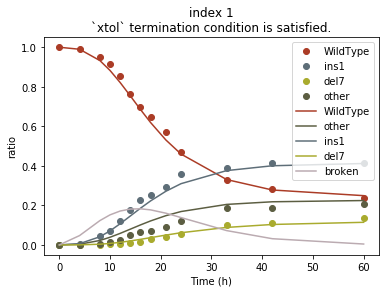

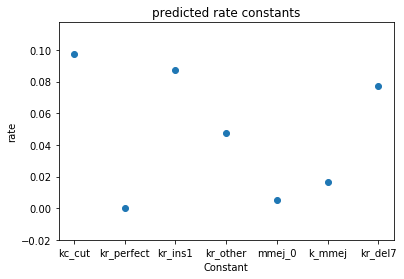

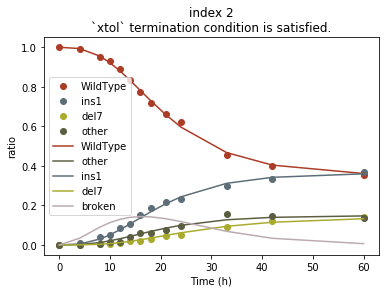

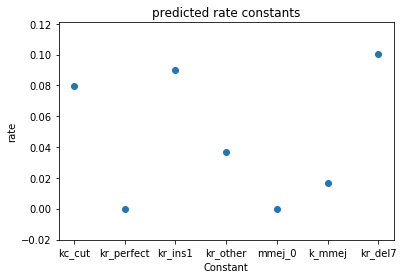

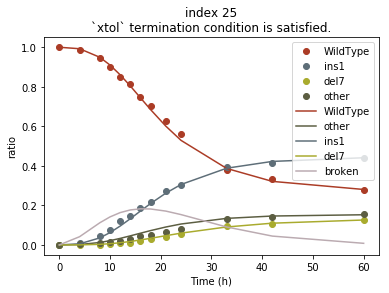

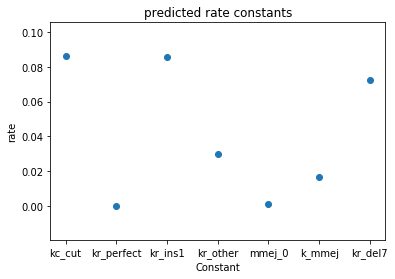

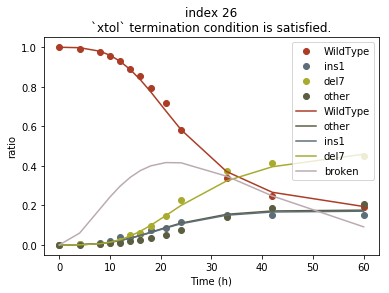

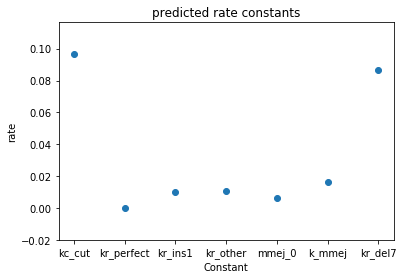

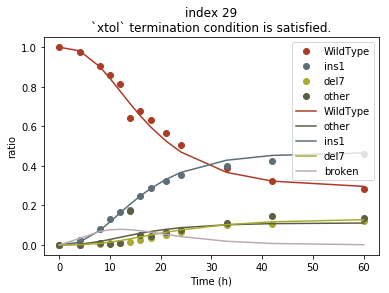

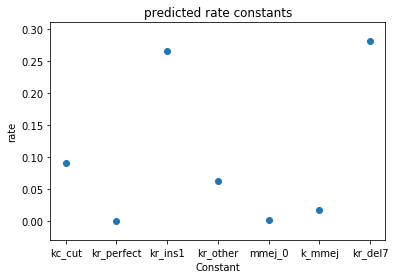

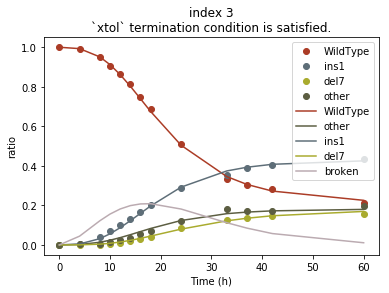

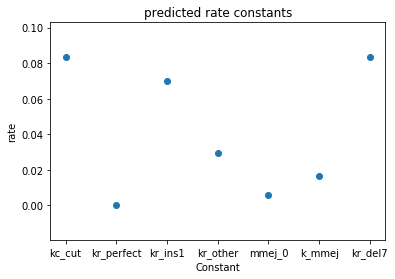

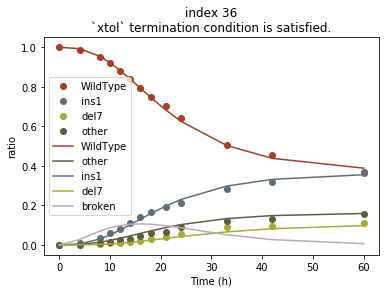

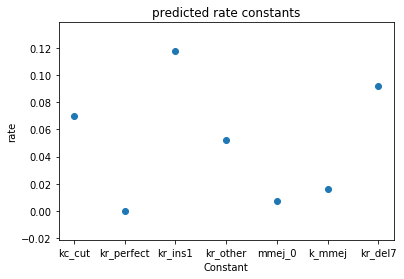

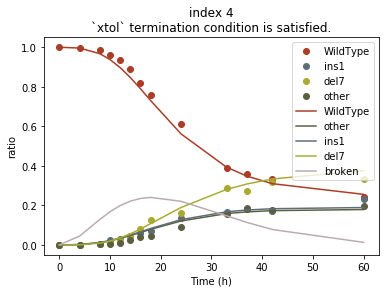

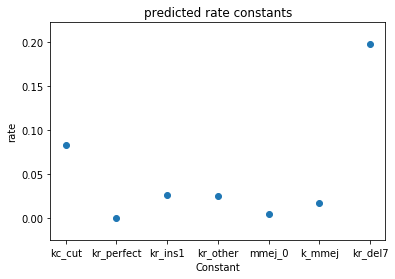

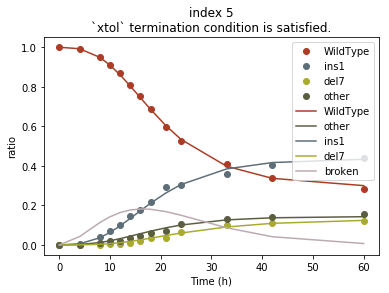

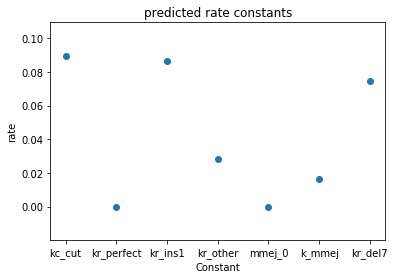

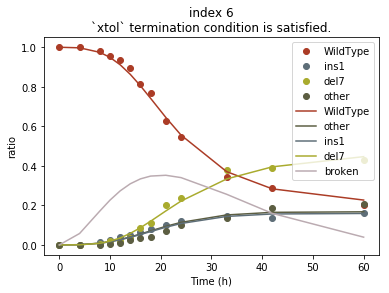

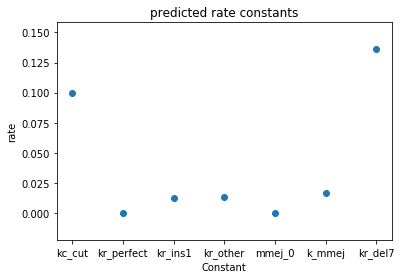

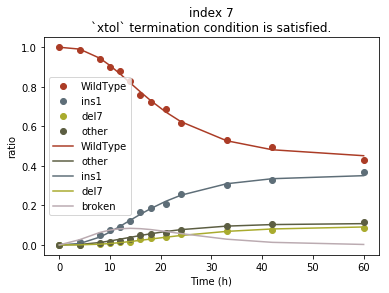

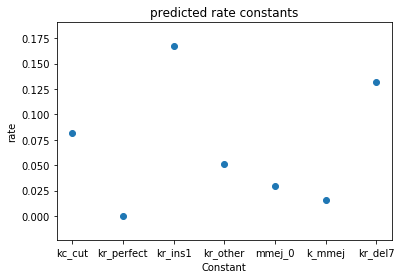

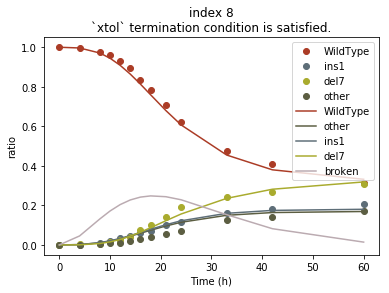

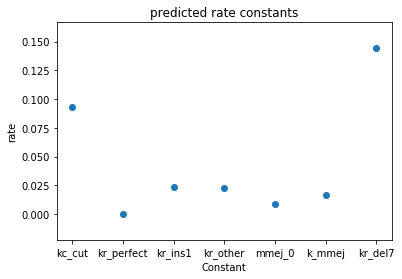

In [9]:

key_list = list(out.keys())
n = len(key_list)


for i in range(0,n):
    pl.ion()
    pl.figure()
    sel = key_list[i]
    res = out[sel]
    m = (previous_data.query("series==@sel")
                      .set_index('time'))
    pl.title('\n'.join((sel, res['mesg'])))
    
    pl.plot(m.index, m.wt, 'o', label="WildType", color=state_color['wt'])
    pl.plot(m.index, m.ins1, 'o', label="ins1", color=state_color['ins1'])
    pl.plot(m.index, m.del7, 'o', label="del7", color=state_color['del7'])
    pl.plot(m.index, m.other, 'o', label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_wt'], label="WildType", color=state_color['wt'])
    pl.plot(res['time'], res['measures']['exp_other'], label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_ins1'], label="ins1", color=state_color['ins1'])
    pl.plot(res['time'], res['measures']['exp_del7'], label="del7", color=state_color['del7'])
    pl.plot(res['time'], res['measures']['exp_broken'], label="broken", color=state_color['broken'])
    pl.legend()
    pl.xlabel("Time (h)")
    pl.ylabel("ratio")

    pl.ion()
    pl.figure()
    pl.title('predicted rate constants')
    solution = combine_param(res.solution, list(start_param.keys()))
    pl.scatter(solution.keys(), solution.values())
    pl.xlabel("Constant")
    pl.ylabel("rate")


In [10]:
state_list = []
x_list = []
y_list = []
for i in range(0,n):
    sel = key_list[i]
    res = out[sel]
    solution = combine_param(res.solution, list(start_param.keys()))
    k_mmej = solution['k_mmej']
    mmej_0 = solution['mmej_0']
    
    kr_min7_0 = mmej_0 * solution['kr_del7']
    
    kr_min7_60 = (mmej_0 + 60 * k_mmej) * solution['kr_del7']
    rate_names = ['kc_cut', 'kr_perfect', 'kr_+1', 'kr_other', 'kr_-7;t=0',
                   'kr_-7;t=60']
    x_list.extend(rate_names)
    y_list.extend([solution['kc_cut'], solution['kr_perfect'],
                   solution['kr_ins1'], solution['kr_other'], kr_min7_0,
                   kr_min7_60])
    state = previous_data.query('series==@sel').get('treatment').iloc[0]
    state_list.extend([state for i in range(0,len(rate_names))])


(0, 0.4)

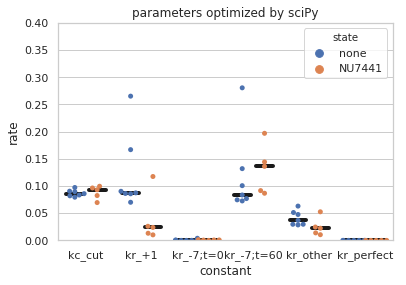

In [11]:
rate_df = pd.DataFrame({'constant':pd.Categorical(x_list),
                        'rate':y_list,
                        'state':state_list})
sns.set(style="whitegrid")
state_order = ['none', 'NU7441']
p = sns.swarmplot(x='constant', y='rate', hue='state', hue_order = state_order, data=rate_df, dodge=True)
plot_mean(p, rate_df, x='constant', y='rate', hue='state', hue_order = state_order, kind='median')
title = plt.title('parameters optimized by sciPy')
plt.ylim((0,0.4))

**conclusion:**

Fits are nice and predictions seem to be more similar between replicates.
Compared to previous implementation, the broken fraction is estimated to be somewhat lower, but still peaks around 16h

However it seems like, similar to -7, the 'other' mutations also have a delay.
We could also use a slope for the 'other' mutations.

The 'other' probably contains both outcomes of NHEJ and MMEJ pathways. I could go back to raw data to find a way to better classify this group.

Another way we could modify the model is to, instead of using a slope, use some 
activation dynamics similar to cas9 activation. So have a rate of activation that plateaus at 1.
This way we will model an activation rate instead of a slope parameter.

## 2 slopes: -7 and 'other' mutations.

let's first have a look at the model using an additional slope parameter for the 'other' mutations.

In [25]:
start_param = {'hlc_cut': 8,
               'hlr_perfect': np.log(2)/1.7e-16,
               'hlr_ins1': 8,
               'hlr_del7_min': 1000,
               'hlr_del7_max': 8,
               'hlr_other_min': 1000,
               'hlr_other_max': 8}


given_param = {'cas_max': p_cas[0],
               'k_cas': p_cas[1]}


In [26]:
out = {name:residuals_model(start_param, slope_model2, group, name,
                            estimates, given_param)
       for name, group in test}

index 1
[6.47421757e+00 8.15467271e+15 1.07270200e+01 2.45938472e+04
 8.29004983e+00 6.97022344e+02 6.75242230e+00]
index 2
[8.06124509e+00 7.13533862e+15 8.73578865e+00 1.95041217e+03
 6.60818141e+00 4.22448697e+02 5.64790172e+00]
index 25
[9.47674365e+00 7.41941637e+15 5.14643835e+00 1.15162790e+10
 5.01182775e+00 6.86445989e+02 4.37814657e+00]
index 26
[5.37561325e+00 5.54578635e+02 1.05203446e+02 6.69642788e+02
 1.22268215e+01 1.63431850e+09 3.47796969e+01]
index 29
[6.41633728e+00 4.07733636e+15 7.19991578e+00 1.00000000e+03
 8.00737504e+00 9.99998259e+02 7.95083937e+00]
index 3
[8.16886474e+00 8.15467271e+15 9.64234743e+00 1.30559771e+03
 6.76349239e+00 8.39632131e+02 5.35966707e+00]
index 36
[1.00415118e+01 5.09667045e+15 5.81957755e+00 2.04252970e+02
 5.77368424e+00 3.14256163e+02 3.68288977e+00]
index 4
[7.24162817e+00 1.46054367e+15 3.84762026e+01 4.80651546e+02
 6.56875543e+00 1.38589596e+03 1.35211194e+01]
index 5
[7.52261235e+00 3.05800227e+15 8.26046169e+00 8.48413343e+03

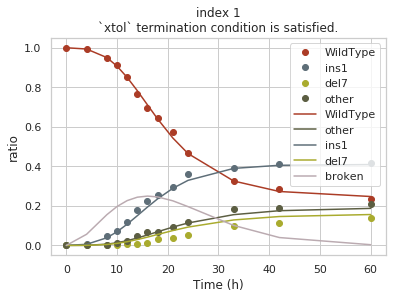

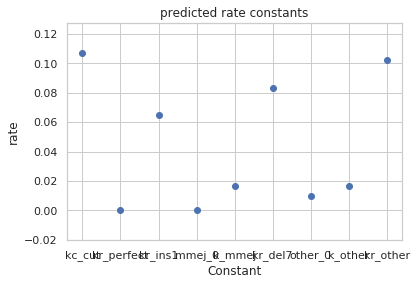

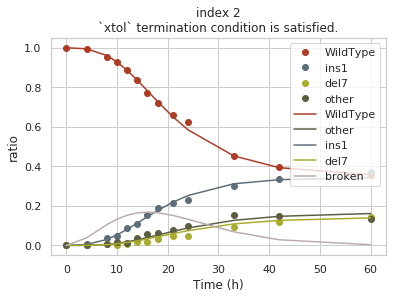

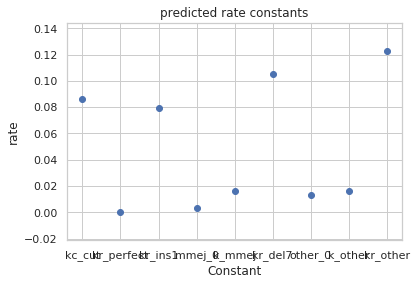

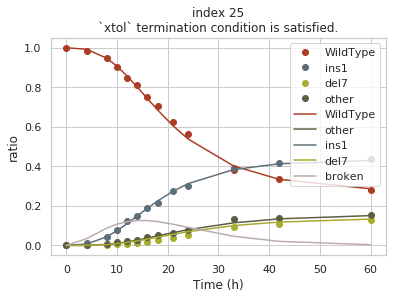

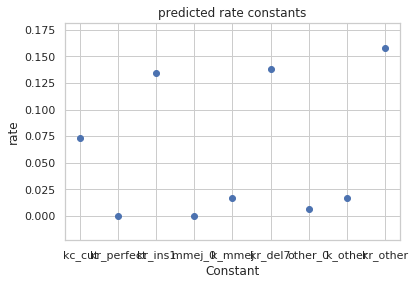

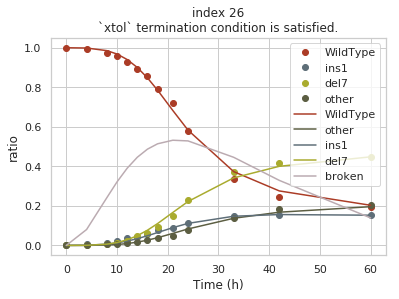

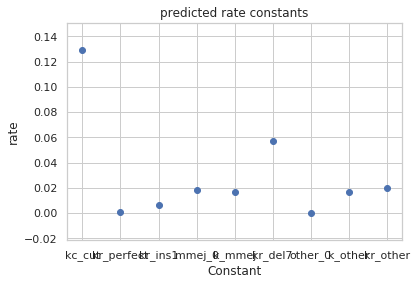

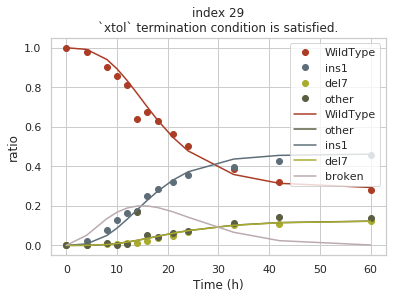

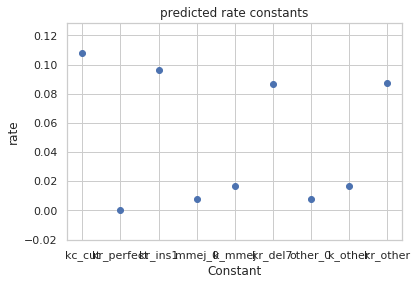

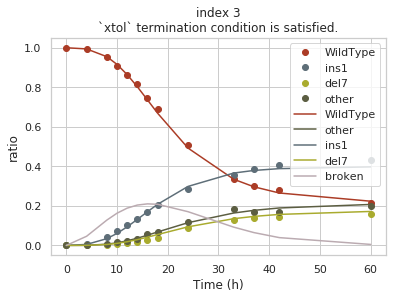

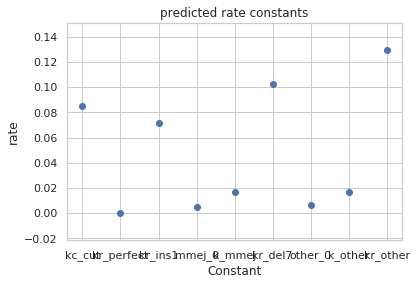

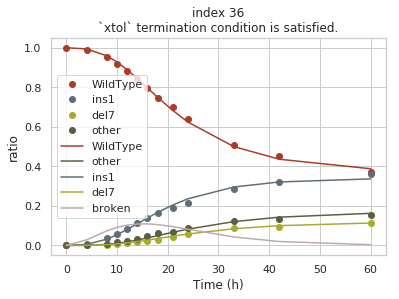

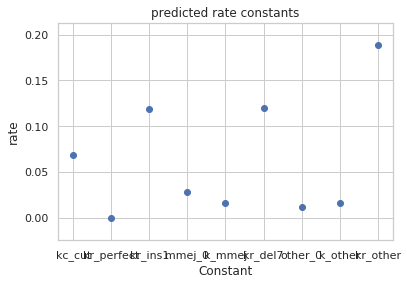

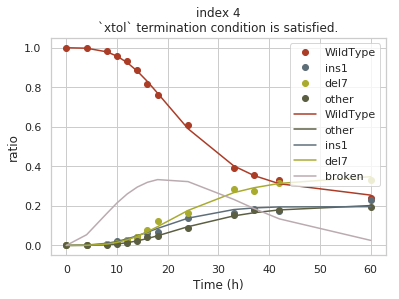

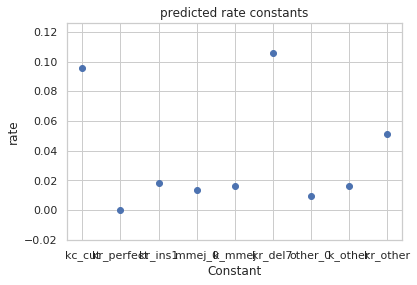

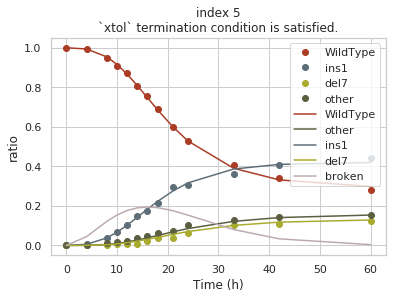

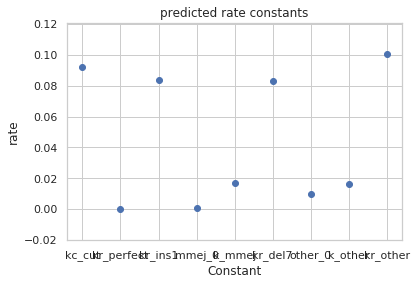

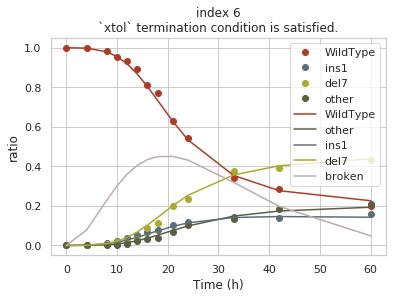

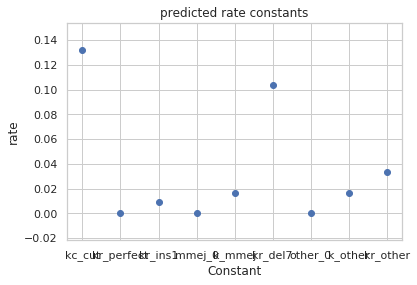

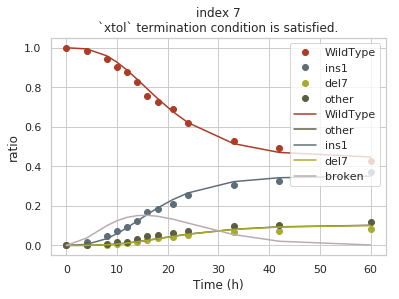

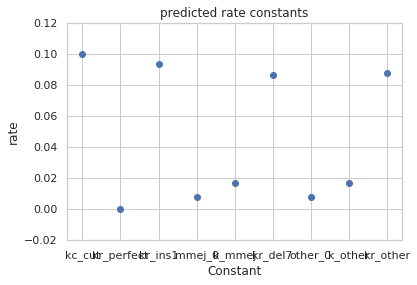

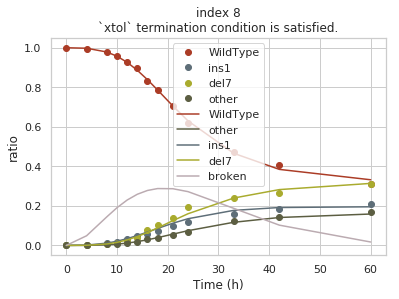

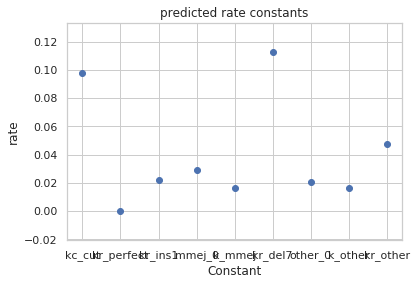

In [27]:

key_list = list(out.keys())
n = len(key_list)


for i in range(0,n):
    pl.ion()
    pl.figure()
    sel = key_list[i]
    res = out[sel]
    m = (previous_data.query("series==@sel")
                      .set_index('time'))
    pl.title('\n'.join((sel, res['mesg'])))
    
    pl.plot(m.index, m.wt, 'o', label="WildType", color=state_color['wt'])
    pl.plot(m.index, m.ins1, 'o', label="ins1", color=state_color['ins1'])
    pl.plot(m.index, m.del7, 'o', label="del7", color=state_color['del7'])
    pl.plot(m.index, m.other, 'o', label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_wt'], label="WildType", color=state_color['wt'])
    pl.plot(res['time'], res['measures']['exp_other'], label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_ins1'], label="ins1", color=state_color['ins1'])
    pl.plot(res['time'], res['measures']['exp_del7'], label="del7", color=state_color['del7'])
    pl.plot(res['time'], res['measures']['exp_broken'], label="broken", color=state_color['broken'])
    pl.legend()
    pl.xlabel("Time (h)")
    pl.ylabel("ratio")

    pl.ion()
    pl.figure()
    pl.title('predicted rate constants')
    solution = combine_param(res.solution, list(start_param.keys()))
    pl.scatter(solution.keys(), solution.values())
    pl.xlabel("Constant")
    pl.ylabel("rate")


In [28]:
state_list = []
x_list = []
y_list = []
for i in range(0,n):
    sel = key_list[i]
    res = out[sel]
    solution = combine_param(res.solution, list(start_param.keys()))
    
    k_mmej = solution['k_mmej']
    mmej_0 = solution['mmej_0']
    kr_min7_0 = mmej_0 * solution['kr_del7']
    kr_min7_60 = (mmej_0 + 60 * k_mmej) * solution['kr_del7']
    
    k_other = solution['k_other']
    other_0 = solution['other_0']
    kr_other_0 = other_0 * solution['kr_other']
    kr_other_60 = (other_0 + 60 * k_other) * solution['kr_other']
    
    
    rate_names = ['kc_cut', 'kr_perfect', 'kr_+1', 'kr_-7;t=0',
                   'kr_-7;t=60', 'kr_other;t=0', 'kr_other;t=60']
    x_list.extend(rate_names)
    y_list.extend([solution['kc_cut'], solution['kr_perfect'],
                   solution['kr_ins1'], kr_min7_0, kr_min7_60,
                   kr_other_0, kr_other_60])
    state = previous_data.query('series==@sel').get('treatment').iloc[0]
    state_list.extend([state for i in range(0,len(rate_names))])

Text(0, 0, 'kc_cut')
Text(0, 0, 'kr_+1')
Text(0, 0, 'kr_-7;t=0')
Text(0, 0, 'kr_-7;t=60')
Text(0, 0, 'kr_other;t=0')
Text(0, 0, 'kr_other;t=60')
Text(0, 0, 'kr_perfect')


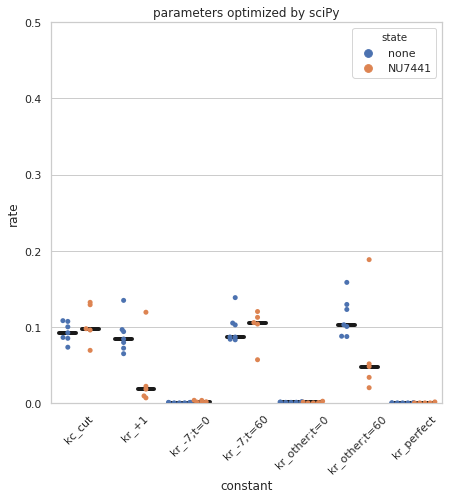

In [29]:
rate_df = pd.DataFrame({'constant':pd.Categorical(x_list),
                        'rate':y_list,
                        'state':state_list})
pl.figure(figsize=(7, 7))
sns.set(style="whitegrid")
state_order = ['none', 'NU7441']
p = sns.swarmplot(x='constant', y='rate', hue='state', hue_order = state_order, data=rate_df, dodge=True)
plot_mean(p, rate_df, x='constant', y='rate', hue='state', hue_order = state_order, kind='median')
for tick in p.get_xticklabels():
    tick.set_multialignment('left')
    print(tick)
    tick.set_rotation(45)
title = plt.title('parameters optimized by sciPy')
plt.ylim((0,0.5))

pl.savefig('cl20190710_old_timeseries_new_model.pdf')

**conclusion:**

Just like MMEJ, kr_other at t=0 seems negligible.
At t=60 all pathways seem to have similar kinetic rates.
In the DNA-PK setting however, kr_other seems to be down.
I think to really understand these kinetics we will need to break down other repair outcomes into different groups.

## Activation parameters for -7.

To me an ever increasing pathway does not make much sense. Using our new way of modeling, we can easily adjust this to use an activation model which starts at and intercept between 0 and 100% and builds up to 100%.

In [17]:
start_param = {'hlc_cut': 8,
               'hlr_perfect': np.log(2)/1.7e-16,
               'hlr_ins1': 8,
               'hl_mmej': 8,
               'hlr_del7': 8,
               'hlr_other': 8}


given_param = {'cas_max': p_cas[0],
               'k_cas': p_cas[1]}

In [18]:
out = {name:residuals_model(start_param, activation_model, group, name,
                            estimates, given_param)
       for name, group in test}

index 1
[6.55851259e+00 5.09508503e+14 8.80838005e+00 3.16551722e+01
 6.86442699e+00 1.69899653e+01]
index 2
[8.65596614e+00 8.15467271e+15 7.09189786e+00 1.76242707e+01
 1.03447878e+01 1.47070764e+01]
index 25
[7.24770449e+00 4.07733636e+15 9.64014680e+00 2.31902236e+01
 1.65770627e+01 2.91302489e+01]
index 26
[6.67828025e+00 8.15467271e+15 7.60521235e+01 2.29186014e+01
 1.18715709e+01 8.15218959e+01]
index 29
[5.91980513e+00 3.05800227e+15 7.16694722e+00 1.45409204e+01
 1.41651844e+01 1.75299382e+01]
index 3
[8.98761844e+00 3.05800227e+15 8.00912566e+00 1.30908563e+01
 1.20806810e+01 1.46052993e+01]
index 36
[8.74859647e+00 6.11600453e+15 8.41060254e+00 8.94354128e+00
 2.01456241e+01 1.99309735e+01]
index 4
[7.91370304e+00 1.06004491e+13 3.34501511e+01 9.62074480e+00
 1.34037153e+01 3.82380742e+01]
index 5
[7.57468516e+00 6.11600453e+15 9.06365795e+00 3.64327517e+01
 5.81208817e+00 2.47580687e+01]
index 6
[6.22665945e+00 1.57005591e+15 6.44929190e+01 1.56670582e+01
 1.21879196e+01 6.

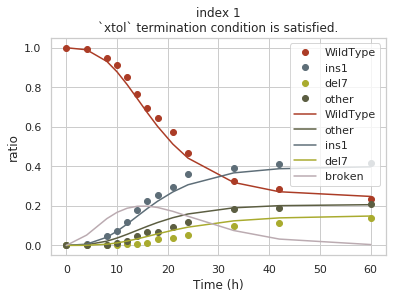

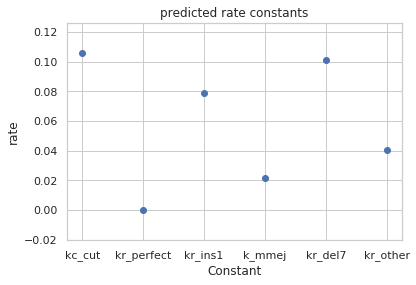

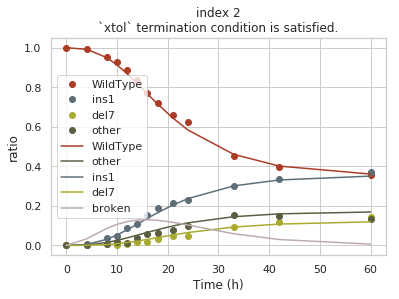

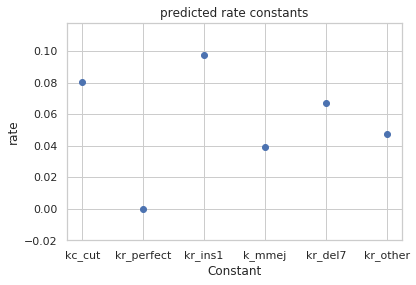

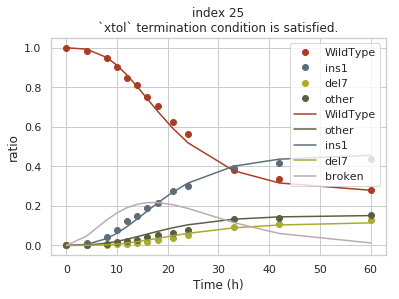

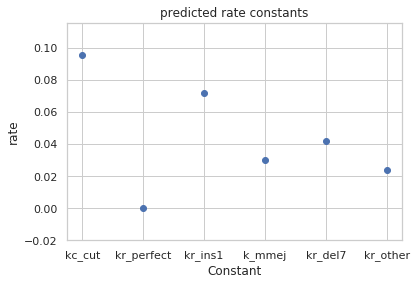

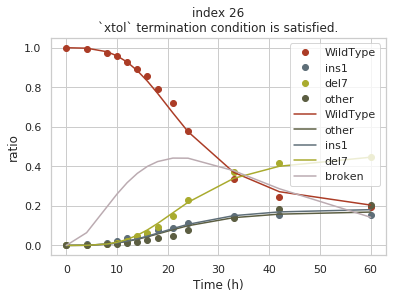

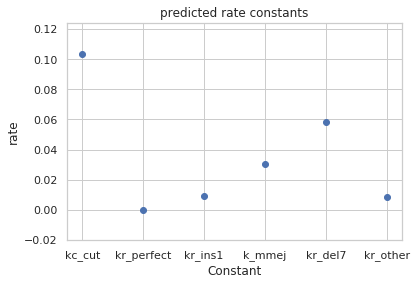

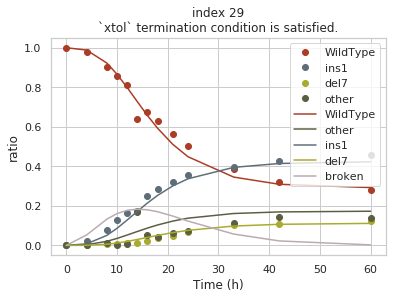

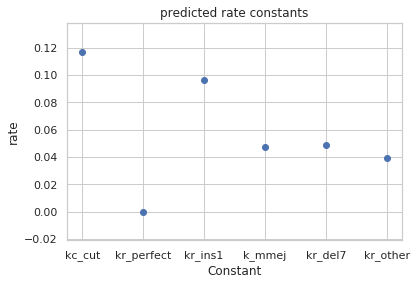

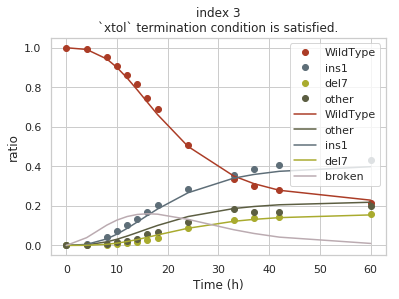

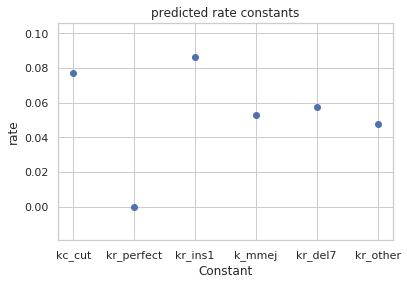

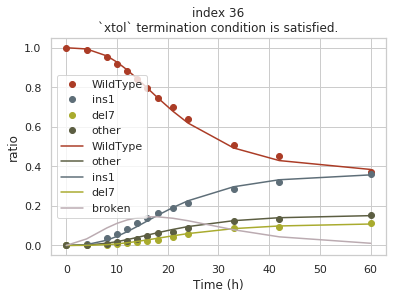

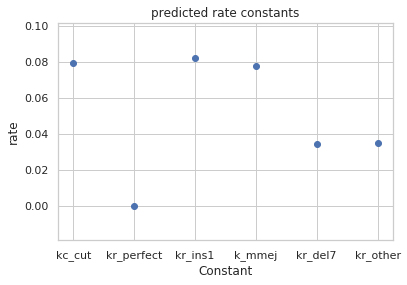

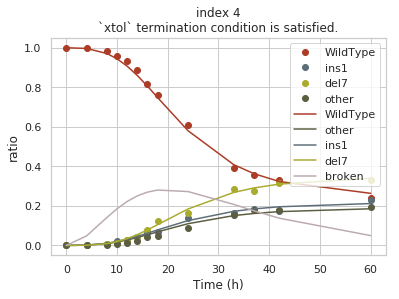

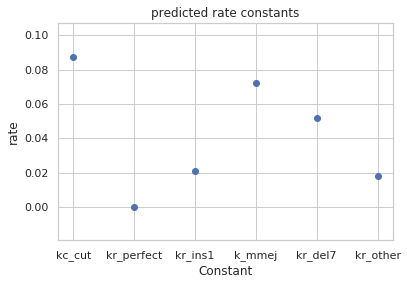

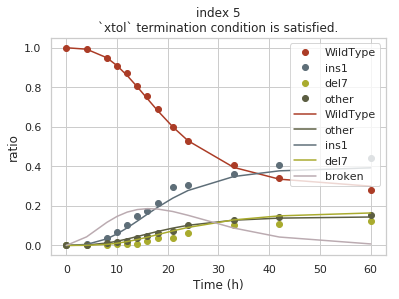

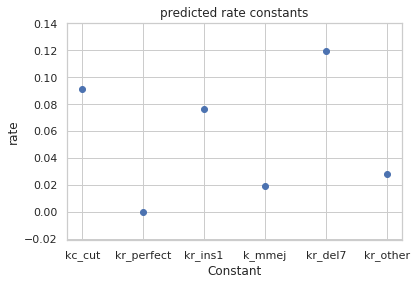

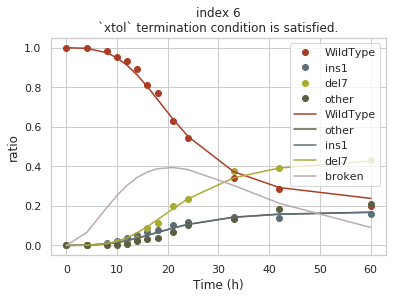

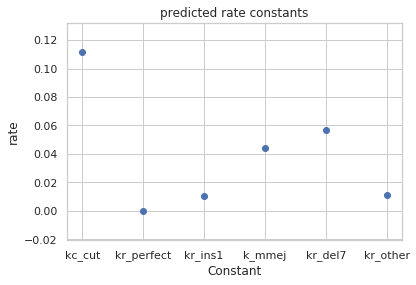

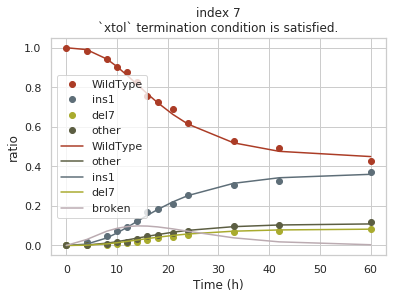

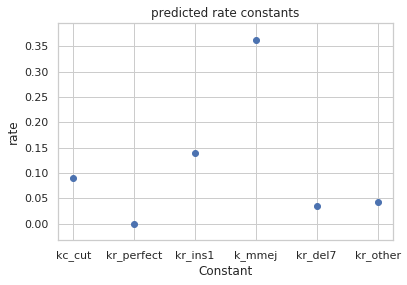

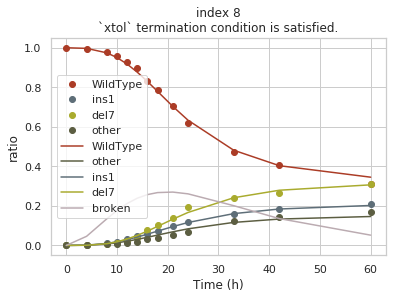

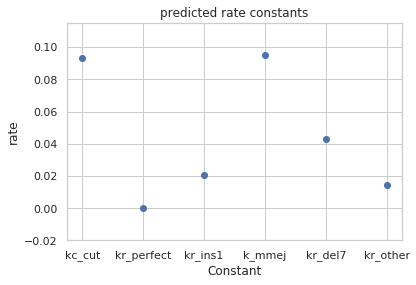

In [19]:

key_list = list(out.keys())
n = len(key_list)


for i in range(0,n):
    pl.ion()
    pl.figure()
    sel = key_list[i]
    res = out[sel]
    m = (previous_data.query("series==@sel")
                      .set_index('time'))
    pl.title('\n'.join((sel, res['mesg'])))
    
    pl.plot(m.index, m.wt, 'o', label="WildType", color=state_color['wt'])
    pl.plot(m.index, m.ins1, 'o', label="ins1", color=state_color['ins1'])
    pl.plot(m.index, m.del7, 'o', label="del7", color=state_color['del7'])
    pl.plot(m.index, m.other, 'o', label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_wt'], label="WildType", color=state_color['wt'])
    pl.plot(res['time'], res['measures']['exp_other'], label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_ins1'], label="ins1", color=state_color['ins1'])
    pl.plot(res['time'], res['measures']['exp_del7'], label="del7", color=state_color['del7'])
    pl.plot(res['time'], res['measures']['exp_broken'], label="broken", color=state_color['broken'])
    pl.legend()
    pl.xlabel("Time (h)")
    pl.ylabel("ratio")

    pl.ion()
    pl.figure()
    pl.title('predicted rate constants')
    solution = combine_param(res.solution, list(start_param.keys()))
    pl.scatter(solution.keys(), solution.values())
    pl.xlabel("Constant")
    pl.ylabel("rate")


In [20]:
state_list = []
x_list = []
y_list = []
for i in range(0,n):
    sel = key_list[i]
    res = out[sel]
    solution = combine_param(res.solution, list(start_param.keys()))
    
    t60 = res['time']==60
    active_mmej = res['measures']['active_MMEJ'][t60]
    kr_min7_60 = active_mmej * solution['kr_del7']
    
    
    rate_names = ['kc_cut', 'kr_perfect', 'kr_+1',
                   'kr_-7;t=60', 'kr_other']
    x_list.extend(rate_names)
    y_list.extend([solution['kc_cut'], solution['kr_perfect'],
                   solution['kr_ins1'], kr_min7_60,
                   solution['kr_other']])
    state = previous_data.query('series==@sel').get('treatment').iloc[0]
    state_list.extend([state for i in range(0,len(rate_names))])

(0, 0.4)

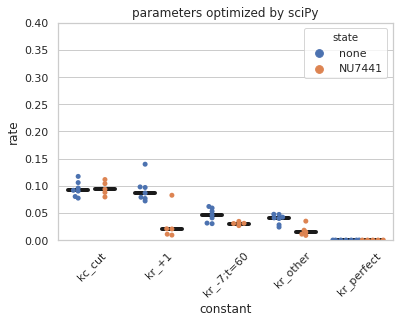

In [21]:
rate_df = pd.DataFrame({'constant':pd.Categorical(x_list),
                        'rate':y_list,
                        'state':state_list})
sns.set(style="whitegrid")
state_order = ['none', 'NU7441']
p = sns.swarmplot(x='constant', y='rate', hue='state', hue_order = state_order, data=rate_df, dodge=True)
plot_mean(p, rate_df, x='constant', y='rate', hue='state', hue_order = state_order, kind='median')
for tick in p.get_xticklabels():
    tick.set_multialignment('left')
    tick.set_rotation(45)
title = plt.title('parameters optimized by sciPy')
plt.ylim((0,0.4))

**conclusion:**

Using this activation constant, predictions seem to be more similar between replicates.
However, some predictions seem to have a higher error rate.

Maybe adding a activation constant for 'other' mutations will help

In [22]:
start_param = {'hlc_cut': 8,
               'hlr_perfect': np.log(2)/1.7e-16,
               'hlr_ins1': 8,
               'hl_mmej': 1,
               'hlr_del7': 8,
               'hl_other': 1,
               'hlr_other': 8}


given_param = {'cas_max': p_cas[0],
               'k_cas': p_cas[1]}

In [23]:
out = {name:residuals_model(start_param, activation_model2, group, name,
                            estimates, given_param)
       for name, group in test}

index 1
[7.46028757e+00 3.05800227e+15 8.29136088e+00 1.30095433e+01
 1.69409215e+01 1.39215543e+01 1.37904814e+01]
index 2
[9.15515298e+00 1.56413709e+15 6.55670499e+00 7.54253240e+00
 1.35448882e+01 3.19405921e+00 1.41638166e+01]
index 25


KeyboardInterrupt: 

In [ ]:

key_list = list(out.keys())
n = len(key_list)


for i in range(0,n):
    pl.ion()
    pl.figure()
    sel = key_list[i]
    res = out[sel]
    m = (previous_data.query("series==@sel")
                      .set_index('time'))
    pl.title('\n'.join((sel, res['mesg'])))
    
    pl.plot(m.index, m.wt, 'o', label="WildType", color=state_color['wt'])
    pl.plot(m.index, m.ins1, 'o', label="ins1", color=state_color['ins1'])
    pl.plot(m.index, m.del7, 'o', label="del7", color=state_color['del7'])
    pl.plot(m.index, m.other, 'o', label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_wt'], label="WildType", color=state_color['wt'])
    pl.plot(res['time'], res['measures']['exp_other'], label="other", color=state_color['other'])
    pl.plot(res['time'], res['measures']['exp_ins1'], label="ins1", color=state_color['ins1'])
    pl.plot(res['time'], res['measures']['exp_del7'], label="del7", color=state_color['del7'])
    pl.plot(res['time'], res['measures']['exp_broken'], label="broken", color=state_color['broken'])
    pl.legend()
    pl.xlabel("Time (h)")
    pl.ylabel("ratio")

    pl.ion()
    pl.figure()
    pl.title('predicted rate constants')
    solution = combine_param(res.solution, list(start_param.keys()))
    pl.scatter(solution.keys(), solution.values())
    pl.xlabel("Constant")
    pl.ylabel("rate")


In [ ]:
state_list = []
x_list = []
y_list = []
for i in range(0,n):
    sel = key_list[i]
    res = out[sel]
    solution = combine_param(res.solution, list(start_param.keys()))
    
    t60 = res['time']==60
    active_mmej = res['measures']['active_MMEJ'][t60]
    kr_min7_60 = active_mmej * solution['kr_del7']
    
    active_other = res['measures']['active_other'][t60]
    kr_other_60 = active_other * solution['kr_other']
    
    rate_names = ['kc_cut', 'kr_perfect', 'kr_+1',
                   'kr_-7;t=60', 'kr_other;t=60']
    x_list.extend(rate_names)
    y_list.extend([solution['kc_cut'], solution['kr_perfect'],
                   solution['kr_ins1'], kr_min7_60,
                   kr_other_60])
    state = previous_data.query('series==@sel').get('treatment').iloc[0]
    state_list.extend([state for i in range(0,len(rate_names))])

In [ ]:
rate_df = pd.DataFrame({'constant':pd.Categorical(x_list),
                        'rate':y_list,
                        'state':state_list})
state_order = ['none', 'NU7441']
pl.figure(figsize=(7, 7))
sns.set(style="whitegrid")
p = sns.swarmplot(x='constant', y='rate', hue='state', hue_order = state_order, data=rate_df, dodge=True)
plot_mean(p, rate_df, x='constant', y='rate', hue='state', hue_order = state_order, kind='median')
for tick in p.get_xticklabels():
    tick.set_multialignment('left')
    tick.set_rotation(45)
title = plt.title('parameters optimized by sciPy')
plt.ylim((0,0.5))


NameError: name 'solution' is not defined

5.034326603221076

2.4320363956365437e-06

21.099442931649502